In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

In [36]:
# Load data before infusion
data_name = "before_df.csv"
data_folder = "data_project"
data_before = pd.read_csv(os.path.join(data_folder, data_name))
data_before.head()

# Load data after infusion
data_name = "after_df.csv"
data_folder = "data_project"
data_after = pd.read_csv(os.path.join(data_folder, data_name))
data_after.head()

,subject,epoch,condition,segment,electrode,el_10-20,N1,N2,N3,R,W,delta,theta,alpha,beta,gamma,offset,exponent
0,P07,0,placebo,after,E144,C2,0.010277,0.010826,0.009872,0.000959,0.968066,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
1,P07,1,placebo,after,E144,C2,0.109079,0.039461,0.043310,0.015815,0.792335,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
2,P07,2,placebo,after,E144,C2,0.023443,0.045758,0.001847,0.001733,0.927220,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
3,P07,3,placebo,after,E144,C2,0.032536,0.115541,0.017605,0.003811,0.830507,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959
4,P07,4,placebo,after,E144,C2,0.029307,0.065396,0.005016,0.001354,0.898928,2.497184,1.618158,1.225892,1.708981,0.485769,0.278161,1.132959


In [37]:
# Compute mean across epochs for epochs having same subject and condition
group_cols = ["subject", "condition"]
feature_cols = data_after.columns[data_after.columns.get_loc("N1") :]

data_after_mean = (
    data_after
    .groupby(group_cols)[feature_cols]
    .mean()
    .reset_index()
)

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

                                  
# Make a copy to avoid modifying the original unintentionally
df_after = data_after.copy()

# Encode target: condition -> 0/1
y_after = (df_after["condition"] == "DMT").astype(int)
print(f"Binary output:\n{y_after.head()}")

# Get index where features start: from column "N1" to the last column
feat_start_idx = df_after.columns.get_loc("N1")
# Make input vector with only features from the data
X_after = df_after.iloc[:, feat_start_idx:]
# Get feature names
feature_names = X_after.columns

scaler = StandardScaler()
X_scaled_after = scaler.fit_transform(X_after)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled_after, y_after, groups=df_after["subject"]))
X_train_after, X_test_after = X_scaled_after[train_idx], X_scaled_after[test_idx]
y_train_after, y_test_after = y_after.iloc[train_idx], y_after.iloc[test_idx]

print(f"X_train shape: {X_train_after.shape}, y_train shape: {y_train_after.shape}")
print(f"X_test shape: {X_test_after.shape}, y_test shape: {y_test_after.shape}")

Binary output:
0    0
1    0
2    0
3    0
4    0
Name: condition, dtype: int64
X_train shape: (40029, 12), y_train shape: (40029,)
X_test shape: (11979, 12), y_test shape: (11979,)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_clf_after = LogisticRegression(max_iter=1000)
log_clf_after.fit(X_train_after, y_train_after)

y_train_pred_after = log_clf_after.predict(X_train_after)
y_test_pred_after = log_clf_after.predict(X_test_after)

print("Train accuracy:", accuracy_score(y_train_after, y_train_pred_after))
print("Test  accuracy:", accuracy_score(y_test_after, y_test_pred_after))
print("\nClassification report (test):\n")
print(classification_report(y_test_after, y_test_pred_after, target_names=["placebo", "DMT"]))

score = log_clf_after.score(X_test_after, y_test_after)
score_train = log_clf_after.score(X_train_after, y_train_after)
print(f'Accuracy score on test set: {score:.2f} (on train set: {score_train:.2f})')


Train accuracy: 0.7229508606260461
Test  accuracy: 0.7068202688037398

Classification report (test):

              precision    recall  f1-score   support

     placebo       0.89      0.53      0.67      6567
         DMT       0.62      0.92      0.74      5412

    accuracy                           0.71     11979
   macro avg       0.75      0.73      0.70     11979
weighted avg       0.77      0.71      0.70     11979

Accuracy score on test set: 0.71 (on train set: 0.72)


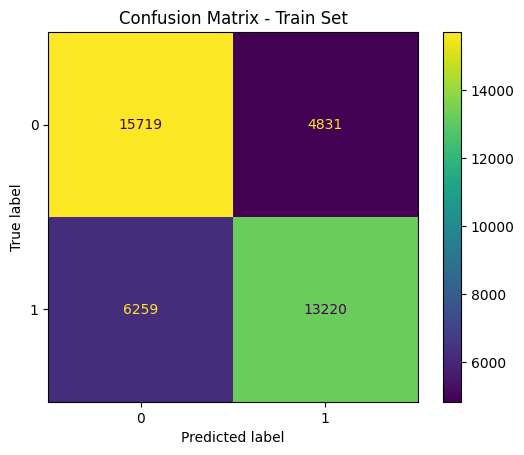

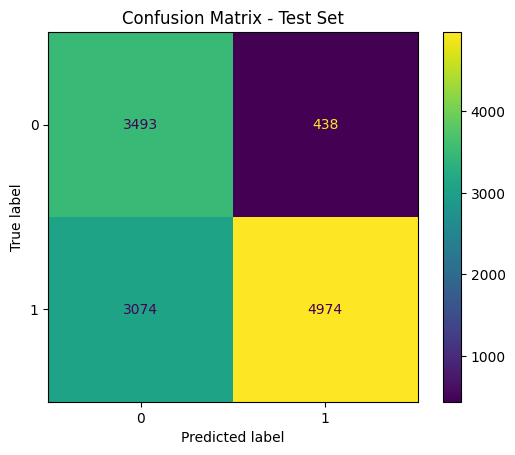

In [48]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_train_pred_after, y_train_after))
disp.plot()
plt.title("Confusion Matrix - Train Set")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix(y_test_pred_after, y_test_after))
disp.plot()
plt.title("Confusion Matrix - Test Set")
plt.show()

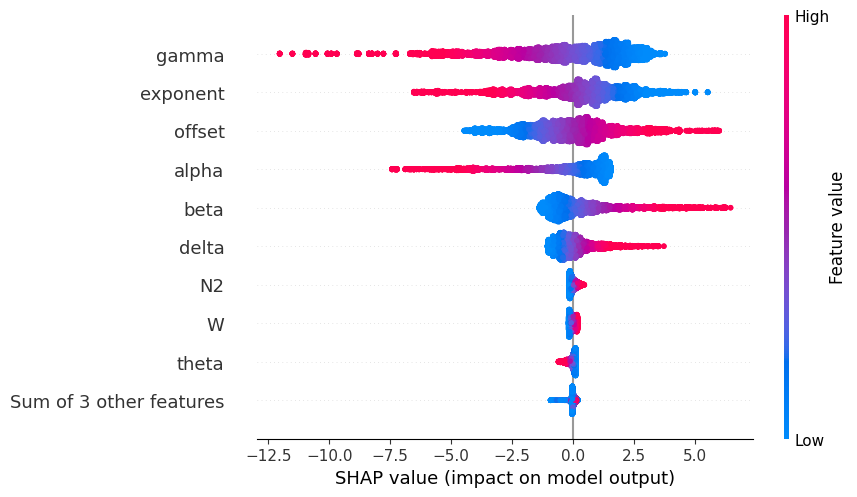

In [41]:
import shap

shap.initjs()

# Use a small background set if X_train is big
X_background = X_train_after.sample(n=min(200, len(X_train_after)), random_state=0)

explainer = shap.LinearExplainer(log_clf_after, X_background, feature_names=feature_names)
shap_values = explainer(X_test_after)

# Global importance (beeswarm)
shap.plots.beeswarm(shap_values)

True label: placebo
Predicted prob DMT: 0.530763734568025


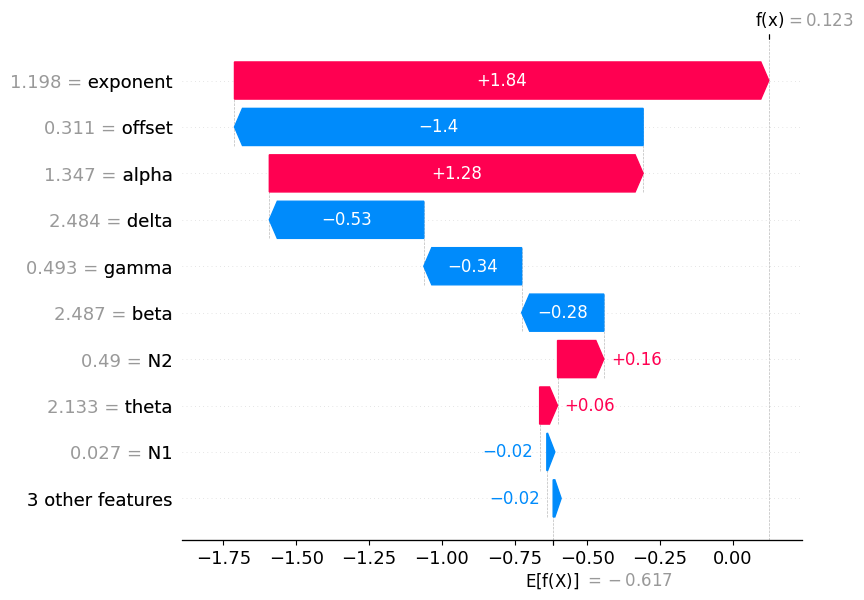

In [42]:
idx = 0  # index in X_test to inspect
print("True label:", "DMT" if y_test_after.iloc[idx] == 1 else "placebo")
print("Predicted prob DMT:", log_clf_after.predict_proba(X_test_after.iloc[[idx]])[0, 1])

shap.plots.waterfall(shap_values[idx])